<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [ ]:
from typing import List

import pandas as pd

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset

sns.set_theme(palette="summer")

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Creating datasets

In [4]:
def preprocess_function(examples, tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )
    tokenized["labels"] = examples["labels"]

    return tokenized

In [6]:
df = pd.read_excel("data/data_problems.xlsx", index_col=0)
df = df.rename(columns={"Задача": "text", "Тема": "labels"})
label_mapping = {label: idx for idx, label in enumerate(df["labels"].unique())}
df["labels"] = df["labels"].map(label_mapping)
dataset = Dataset.from_pandas(df)

In [5]:
eng_df = pd.read_excel("data/data_problems_translated.xlsx", index_col=0)
eng_df = eng_df.dropna()
eng_df = eng_df.rename(columns={"problem_text": "text", "topic": "labels"})
label_mapping = {label: idx for idx, label in enumerate(eng_df["labels"].unique())}
eng_df["labels"] = eng_df["labels"].map(label_mapping)
eng_dataset = Dataset.from_pandas(eng_df)

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [71]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model, num_classes=7):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(
            base_transformer_model, output_attentions=True
        )
        hidden_size = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls_representation = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_representation)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [8]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
def train_transformer(transformer_model, dataset, device, freeze_backbone=True):
    if freeze_backbone:
        freeze_backbone_function(transformer_model)
    model = transformer_model.to(device)

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        learning_rate=2e-5,
        eval_strategy="epoch",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=4,
        weight_decay=0.01,
        save_total_limit=3,
        save_strategy="no",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
    )
    trainer.train()

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [22]:
rubert_dataset = dataset.map(
    lambda examples: preprocess_function(examples, "cointegrated/rubert-tiny2"),
    batched=True,
)
rubert_dataset = rubert_dataset.train_test_split(test_size=0.2)
rubert_dataset

Map:   0%|          | 0/5273 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4218
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1055
    })
})

In [9]:
rubert_tiny_transformer_model = TransformerClassificationModel(
    "cointegrated/rubert-tiny2"
)
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(
    rubert_tiny_transformer_model, rubert_dataset, device=device, freeze_backbone=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3165 [00:00<?, ?it/s]

{'loss': 1.8317, 'grad_norm': 5.958548545837402, 'learning_rate': 1.6840442338072673e-05, 'epoch': 0.47}
{'loss': 1.6727, 'grad_norm': 4.322985649108887, 'learning_rate': 1.368088467614534e-05, 'epoch': 0.95}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.6253998279571533, 'eval_runtime': 21.4998, 'eval_samples_per_second': 49.07, 'eval_steps_per_second': 12.279, 'epoch': 1.0}
{'loss': 1.6024, 'grad_norm': 7.530872821807861, 'learning_rate': 1.052132701421801e-05, 'epoch': 1.42}
{'loss': 1.553, 'grad_norm': 5.261442184448242, 'learning_rate': 7.36176935229068e-06, 'epoch': 1.9}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.554624319076538, 'eval_runtime': 21.4711, 'eval_samples_per_second': 49.136, 'eval_steps_per_second': 12.296, 'epoch': 2.0}
{'loss': 1.5454, 'grad_norm': 4.241700172424316, 'learning_rate': 4.20221169036335e-06, 'epoch': 2.37}
{'loss': 1.5344, 'grad_norm': 4.032405853271484, 'learning_rate': 1.042654028436019e-06, 'epoch': 2.84}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.5382590293884277, 'eval_runtime': 21.5934, 'eval_samples_per_second': 48.857, 'eval_steps_per_second': 12.226, 'epoch': 3.0}
{'train_runtime': 386.1727, 'train_samples_per_second': 32.768, 'train_steps_per_second': 8.196, 'train_loss': 1.6166682479882504, 'epoch': 3.0}


In [72]:
rubert_tiny_transformer_model = TransformerClassificationModel(
    "cointegrated/rubert-tiny2"
)
rubert_tiny_full_finetuned = train_transformer(
    rubert_tiny_transformer_model, rubert_dataset, device=device, freeze_backbone=False
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/6327 [00:00<?, ?it/s]

{'loss': 1.4624, 'grad_norm': 19.311960220336914, 'learning_rate': 1.8419472103682632e-05, 'epoch': 0.24}
{'loss': 1.2082, 'grad_norm': 50.041595458984375, 'learning_rate': 1.6838944207365262e-05, 'epoch': 0.47}
{'loss': 1.1799, 'grad_norm': 5.670027256011963, 'learning_rate': 1.5258416311047893e-05, 'epoch': 0.71}
{'loss': 1.1421, 'grad_norm': 49.592105865478516, 'learning_rate': 1.367788841473052e-05, 'epoch': 0.95}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.1338735818862915, 'eval_runtime': 2.3117, 'eval_samples_per_second': 456.382, 'eval_steps_per_second': 114.204, 'epoch': 1.0}
{'loss': 1.0555, 'grad_norm': 0.5223003625869751, 'learning_rate': 1.209736051841315e-05, 'epoch': 1.19}
{'loss': 1.0145, 'grad_norm': 28.33901596069336, 'learning_rate': 1.051683262209578e-05, 'epoch': 1.42}
{'loss': 0.9807, 'grad_norm': 48.41465377807617, 'learning_rate': 8.936304725778411e-06, 'epoch': 1.66}
{'loss': 0.994, 'grad_norm': 59.50175857543945, 'learning_rate': 7.355776829461041e-06, 'epoch': 1.9}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.1185446977615356, 'eval_runtime': 2.3048, 'eval_samples_per_second': 457.731, 'eval_steps_per_second': 114.541, 'epoch': 2.0}
{'loss': 0.9518, 'grad_norm': 78.3519515991211, 'learning_rate': 5.77524893314367e-06, 'epoch': 2.13}
{'loss': 0.9167, 'grad_norm': 0.10305184125900269, 'learning_rate': 4.1947210368263005e-06, 'epoch': 2.37}
{'loss': 0.8886, 'grad_norm': 0.5092947483062744, 'learning_rate': 2.6141931405089304e-06, 'epoch': 2.61}
{'loss': 0.9474, 'grad_norm': 98.95782470703125, 'learning_rate': 1.0336652441915602e-06, 'epoch': 2.84}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.160430669784546, 'eval_runtime': 2.3265, 'eval_samples_per_second': 453.462, 'eval_steps_per_second': 113.473, 'epoch': 3.0}
{'train_runtime': 147.4051, 'train_samples_per_second': 85.845, 'train_steps_per_second': 42.923, 'train_loss': 1.0499208491617646, 'epoch': 3.0}


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [10]:
mathbert_dataset = eng_dataset.map(
    lambda examples: preprocess_function(examples, "tbs17/MathBert"), batched=True
)
mathbert_dataset = mathbert_dataset.train_test_split(test_size=0.2)
mathbert_dataset

Map:   0%|          | 0/5269 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4215
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1054
    })
})

In [19]:
mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBert")
mathbert_finetuned_with_freezed_backbone = train_transformer(
    mathbert_transformer_model, mathbert_dataset, device=device, freeze_backbone=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/6324 [00:00<?, ?it/s]

{'loss': 1.699, 'grad_norm': 13.529487609863281, 'learning_rate': 1.8418722327640734e-05, 'epoch': 0.24}
{'loss': 1.6436, 'grad_norm': 13.383378982543945, 'learning_rate': 1.683744465528147e-05, 'epoch': 0.47}
{'loss': 1.5403, 'grad_norm': 21.823802947998047, 'learning_rate': 1.5256166982922202e-05, 'epoch': 0.71}
{'loss': 1.5565, 'grad_norm': 11.400967597961426, 'learning_rate': 1.3674889310562936e-05, 'epoch': 0.95}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.5845117568969727, 'eval_runtime': 14.5763, 'eval_samples_per_second': 72.309, 'eval_steps_per_second': 18.112, 'epoch': 1.0}
{'loss': 1.542, 'grad_norm': 15.911665916442871, 'learning_rate': 1.2093611638203671e-05, 'epoch': 1.19}
{'loss': 1.5118, 'grad_norm': 13.320746421813965, 'learning_rate': 1.0512333965844403e-05, 'epoch': 1.42}
{'loss': 1.4874, 'grad_norm': 15.198837280273438, 'learning_rate': 8.931056293485137e-06, 'epoch': 1.66}
{'loss': 1.5149, 'grad_norm': 14.684317588806152, 'learning_rate': 7.3497786211258706e-06, 'epoch': 1.9}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.5359586477279663, 'eval_runtime': 13.7319, 'eval_samples_per_second': 76.756, 'eval_steps_per_second': 19.225, 'epoch': 2.0}
{'loss': 1.4673, 'grad_norm': 15.809137344360352, 'learning_rate': 5.768500948766604e-06, 'epoch': 2.13}
{'loss': 1.492, 'grad_norm': 16.1750431060791, 'learning_rate': 4.187223276407337e-06, 'epoch': 2.37}
{'loss': 1.4357, 'grad_norm': 14.776923179626465, 'learning_rate': 2.6059456040480714e-06, 'epoch': 2.61}
{'loss': 1.4954, 'grad_norm': 8.341608047485352, 'learning_rate': 1.0246679316888046e-06, 'epoch': 2.85}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.5236347913742065, 'eval_runtime': 14.9195, 'eval_samples_per_second': 70.646, 'eval_steps_per_second': 17.695, 'epoch': 3.0}
{'train_runtime': 246.8661, 'train_samples_per_second': 51.222, 'train_steps_per_second': 25.617, 'train_loss': 1.5337893819597836, 'epoch': 3.0}


In [85]:
mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBert")
mathbert_full_finetuned = train_transformer(
    mathbert_transformer_model, mathbert_dataset, device=device, freeze_backbone=False
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/6324 [00:00<?, ?it/s]

{'loss': 1.5345, 'grad_norm': 31.69664192199707, 'learning_rate': 1.8418722327640734e-05, 'epoch': 0.24}
{'loss': 1.3053, 'grad_norm': 0.43569430708885193, 'learning_rate': 1.683744465528147e-05, 'epoch': 0.47}
{'loss': 1.2561, 'grad_norm': 44.691925048828125, 'learning_rate': 1.5256166982922202e-05, 'epoch': 0.71}
{'loss': 1.1691, 'grad_norm': 25.24995231628418, 'learning_rate': 1.3674889310562936e-05, 'epoch': 0.95}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.2074475288391113, 'eval_runtime': 15.5913, 'eval_samples_per_second': 67.602, 'eval_steps_per_second': 16.932, 'epoch': 1.0}
{'loss': 1.0099, 'grad_norm': 34.1350212097168, 'learning_rate': 1.2093611638203671e-05, 'epoch': 1.19}
{'loss': 1.0376, 'grad_norm': 0.4226480722427368, 'learning_rate': 1.0512333965844403e-05, 'epoch': 1.42}
{'loss': 0.9601, 'grad_norm': 29.52142906188965, 'learning_rate': 8.931056293485137e-06, 'epoch': 1.66}
{'loss': 0.9617, 'grad_norm': 14.580307006835938, 'learning_rate': 7.3497786211258706e-06, 'epoch': 1.9}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.3088691234588623, 'eval_runtime': 17.0501, 'eval_samples_per_second': 61.818, 'eval_steps_per_second': 15.484, 'epoch': 2.0}
{'loss': 0.8229, 'grad_norm': 0.6897309422492981, 'learning_rate': 5.768500948766604e-06, 'epoch': 2.13}
{'loss': 0.7199, 'grad_norm': 55.429813385009766, 'learning_rate': 4.187223276407337e-06, 'epoch': 2.37}
{'loss': 0.6894, 'grad_norm': 9.971293449401855, 'learning_rate': 2.6059456040480714e-06, 'epoch': 2.61}
{'loss': 0.7256, 'grad_norm': 0.37811559438705444, 'learning_rate': 1.0246679316888046e-06, 'epoch': 2.85}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.5128031969070435, 'eval_runtime': 17.3234, 'eval_samples_per_second': 60.843, 'eval_steps_per_second': 15.239, 'epoch': 3.0}
{'train_runtime': 870.7138, 'train_samples_per_second': 14.523, 'train_steps_per_second': 7.263, 'train_loss': 1.0037482428746762, 'epoch': 3.0}


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [57]:
def draw_first_layer_attention_maps(
    attention_head_ids: List,
    text: str,
    model: TransformerClassificationModel,
    tokenizer_name: str,
):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    model = model.backbone
    model.eval()
    with torch.no_grad():
        outputs = model(inputs["input_ids"], inputs["attention_mask"])

    attentions = outputs.attentions
    first_layer_attention = attentions[0]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
    for head_id in attention_head_ids:
        attention_map = first_layer_attention[0, head_id].detach().cpu().numpy()
        fig, ax = plt.subplots(figsize=(4, 3))
        sns.heatmap(
            attention_map, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax
        )

        ax.set_xlabel("Tokens")
        ax.set_ylabel("Tokens")
        ax.set_title(f"Layer 1 Attention - Head {head_id}")

        plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

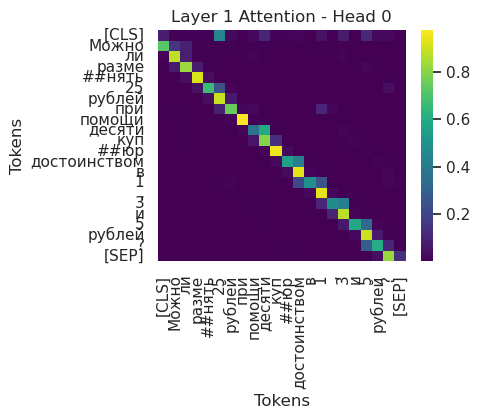

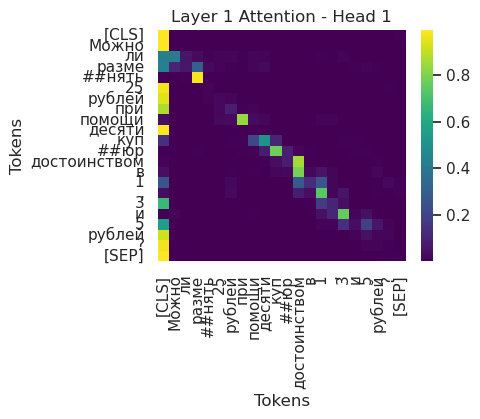

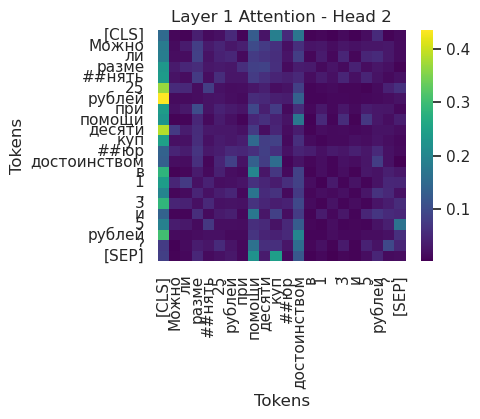

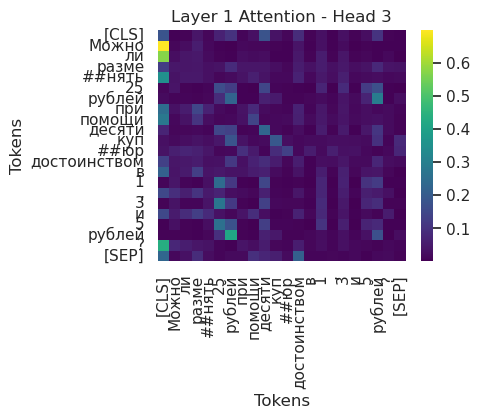

In [58]:
rubert = TransformerClassificationModel("cointegrated/rubert-tiny2")
test = rubert_dataset["train"][135]["text"]
draw_first_layer_attention_maps([0, 1, 2, 3], test, rubert, "cointegrated/rubert-tiny2")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


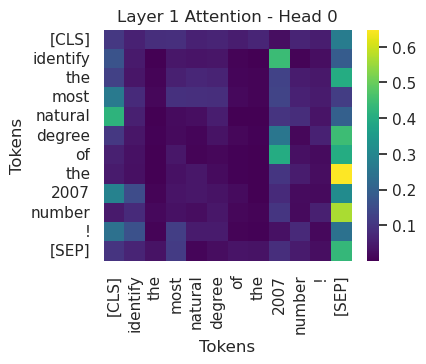

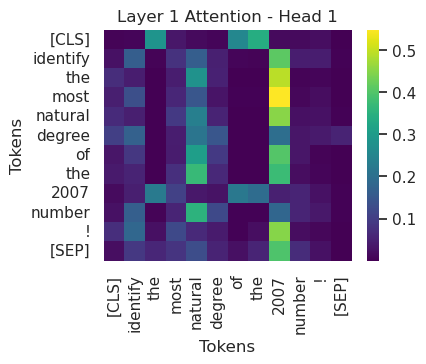

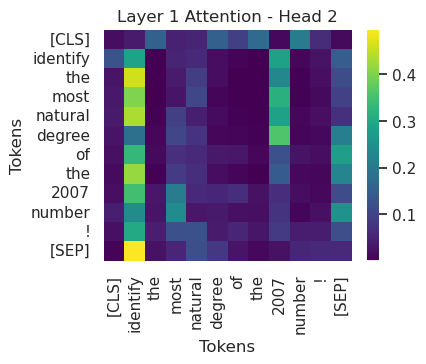

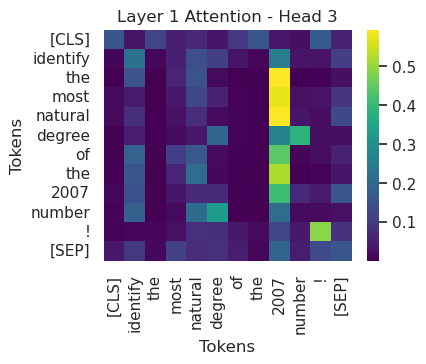

In [106]:
mathbert = TransformerClassificationModel("tbs17/MathBert")
test = mathbert_dataset["train"][505]["text"]
draw_first_layer_attention_maps([0, 1, 2, 3], test, mathbert, "tbs17/MathBert")

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

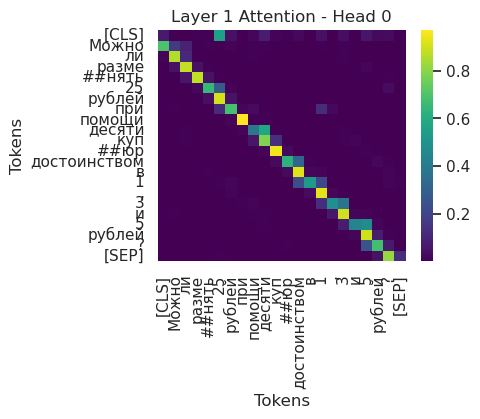

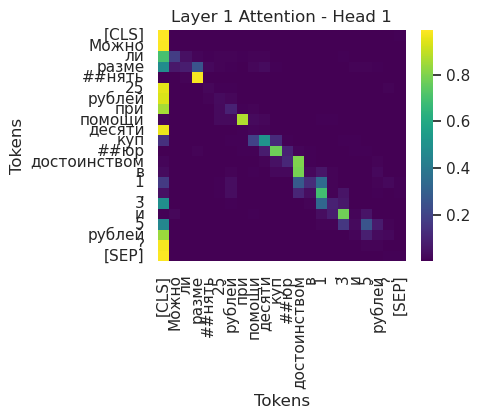

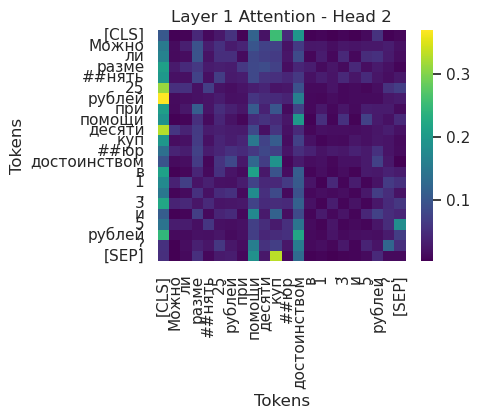

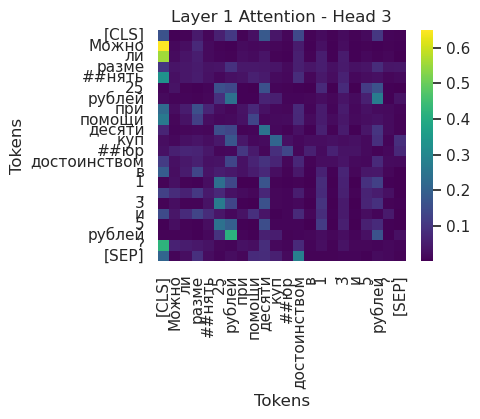

In [ ]:
test = rubert_dataset["train"][135]["text"]
draw_first_layer_attention_maps(
    [0, 1, 2, 3], test, rubert_tiny_transformer_model.cpu(), "cointegrated/rubert-tiny2"
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


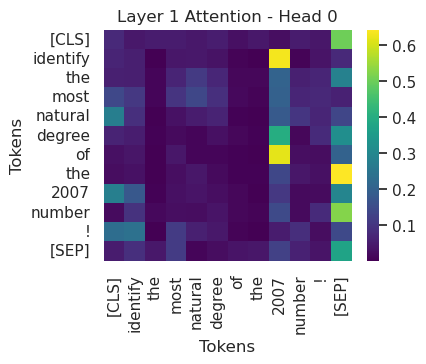

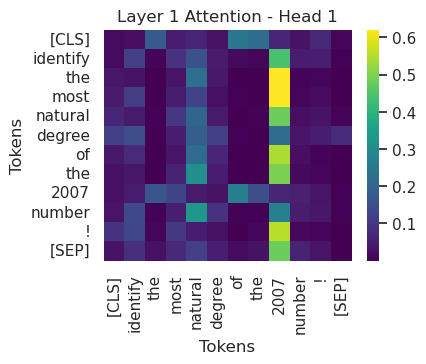

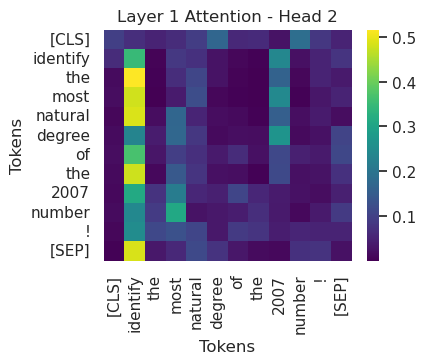

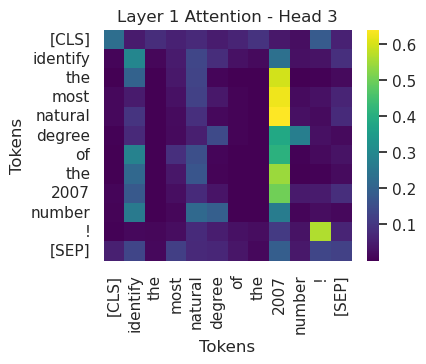

In [108]:
test = mathbert_dataset["train"][505]["text"]
draw_first_layer_attention_maps(
    [0, 1, 2, 3], test, mathbert_transformer_model.cpu(), "tbs17/MathBert"
)

# Выводы

Результаты моделей mathbert и rubert оказались достаточно схожими, в целом можно сказать, что модели без замороженных слоев показали лучший результат. Среди моделей с заморозкой backbone-части лучшей оказалась модель с mathbert, а без заморозки - rubert, у mathbert при обучении без заморозки наблюдаются признаки переобучения (loss падает на train и растет на test).

Можно заметить, что карты активации голов attention немного отличаются у базовых и дообученных моделей. У модели rubert 1 и 2 головы (индексация с 0) сильно реагируют на токен классификации cls, у mathbert такой особенности не наблюдается.